# Install extra dependencies

In [1]:
!pip install -q torchinfo accelerate tqdm

# Imports

In [2]:
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# pytorch dependency
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor

# HuggingFace accelerate library
from accelerate import Accelerator # (easy support for multiple GPU's, TPU, floating point 16s, which makes training much faster)

# displaying the pytorch architecture (makes prototyping the network easier, as it shows shapes)
from torchinfo import summary

# plotting the results
import matplotlib.pyplot as plt
import seaborn as sns 

# creatation and transformations for the dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image

from collections import defaultdict

from IPython.display import clear_output

# show nice progress bar
from tqdm.auto import tqdm

from time import time

2023-06-22 17:44:23.678016: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-22 17:44:23.797614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 17:44:24.407060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Config 

In [6]:
class CONFIG:
    # use the 16 bit floating point arithmetic (should speeds up training/inference)
    USE_MIXED_PRECISION = "fp16"    # other values possible, "fp16" or None

    # set to true to read the dataset from kaggle, false when doing locally
    USE_KAGGLE = False

    # downscaling the images : to make the inference on kaggle faster and keep within reason on GPU there, 
    #                          I set it to 2 (so the image is scaled from (256,256) to (128, 128)), None 
    #                          keeps the original shape 
    DOWNSCALE = None

    # Imagenet channelwise mean
    MEAN = [0.485, 0.456, 0.406]

    # imagenet, channelwise standard deviation
    STD = [0.229, 0.224, 0.225]

    # epsilon for DICE, IoU losses (now 1e-6, however in some papers set to 1)
    EXTRA_LOSS_EPS = 1e-6

    # style of plots, I find darkgrid nice for regular plots
    SNS_STYLE = "darkgrid"

    BATCH_SIZE = 8

    SINGLE_NETWORK_TRAINING_EPOCHS = 15

    CE_VS_DICE_EVAL_EPOCHS = 15

    DELTA_BETA = 0.2

cfg = CONFIG()    

# get filepaths

In [7]:
# if on kaggle, use the kaggle datapath
if cfg.USE_KAGGLE:
    datapath = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")

# otherwise locally
else:
    datapath = os.path.join("dataset", "cityscapes_data")

# setting up the datapaths
train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")
train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")

# list all, full datapaths for training and validation images and save them in these two variables
training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]

# sanity check, how many images
print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


In [8]:
# Create a HuggingFace Accelerate accelerator. This allows using multiple GPUs, TPUs or 
# mixed precision (like brain-float16 or 16bit floating points) which should make training/inference 
# faster
if cfg.USE_MIXED_PRECISION is not None:
    accelerator = Accelerator(mixed_precision=cfg.USE_MIXED_PRECISION)
else:
    accelerator = Accelerator()

# Data visualization
Firstly, inspect the dataset to see what the data looks like. Below few random images from the dataset are plotted <br>
Unfortunately in this dataset, we are not provided with separate mask data, but data is a single image which is a concatenation of input image and RGB mask representation. This makes it trickier to work with

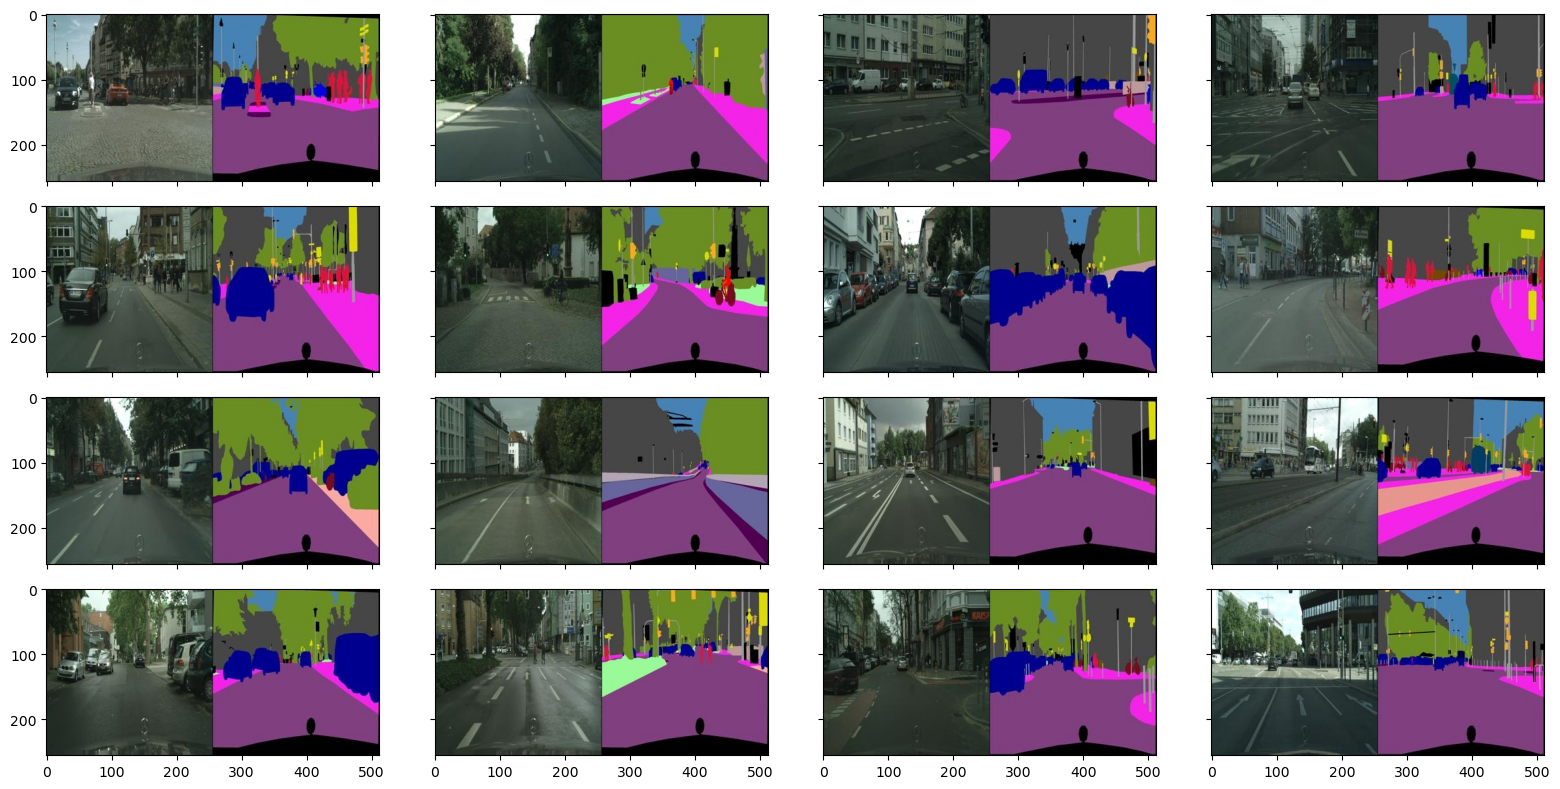

In [9]:
# how many images (total width * height)
width = 4
height = 4
vis_batch_size = width * height

# get vis_batch_size unique, random indices
indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]

# create the plot 
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))
for i in range(vis_batch_size):
    # read the image
    img = torchvision.io.read_image(training_images_paths[indexes[i]])

    # pytorch reads it as (c, h, w), reshape it to (h, w, c) which is the shape matplotlib wants
    img = img.permute(1, 2, 0)
    
    # calculate the indexes for plots and set the image data
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

# Data preprocessing
## labels 
To restore the categories information from a single jpg image, we firstly get the names and categories from the cited cityscapes repository. We get the color representation of each of these classes (I decided to work with categories rather than names), and save it to *idx_to_color*. For each pixel then of an input jpg image, we find a closest color, and put there the index of category which represent this color. this will give us the required (height, width, num_of_classes) representation. <br><br>
This is achieved by code below

In [10]:
# reference
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


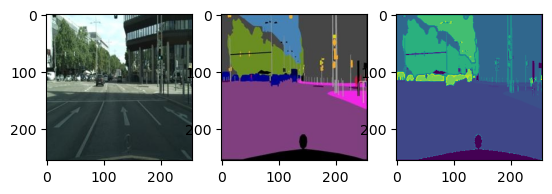

In [11]:
from typing import Tuple

# vectorize the operation of getting the name to category for numpy (just a lookup in name_to_category dictionary)
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

# vectorize the operation of mapping the name to color for numpy (just a lookup in idx_to_color dictionary)
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path : str, sparse_mapping=True, downscale_factor=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg 
        and conversion to categories or names (if sparse_mapping is true) representation (256 x 256 x (|categories| or |names|) )
    """
    # Read the image from path and dowscale if downscale_factor is not None.
    img = Image.open(path)
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
    img = np.asarray(img)
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape

    # compute then the sum of squared distances for each pixel to the colors (L2 between the color and pixel data) : 
    # the value which will be the minimal is the category name we will use for that pixel, and we will get it using argmin
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)

    # if we want to operate on names, map the categories to names
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes


x, mask_raw, classes = preprocess_image(training_images_paths[indexes[i]], sparse_mapping=False, downscale_factor=None)

# sanity checks and print the data
print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

# Load data and Pytorch dataset
In the section below, we will create and check the Pytorch dataset for this images 

## Load dataset
There aren't that many images for training/validation and the size of them is pretty small, therefore to speed up the computation, we can
just load them into RAM. This will be achieved by preprocessing as above all paths, and appending the input images and proper masks to python arrays <br><br>
The images themselves are scaled to [0, 1] and converted to PyTorch Tensors (with the (c, h, w) convention )

In [12]:
train_images_to_use = -1

# for kaggle
downscale_factor=cfg.DOWNSCALE

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(training_images_paths[:]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}")
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


In [14]:
total_size_in_B = 0

for i in range(len(X_train)):
    total_size_in_B += X_train[i].element_size() * X_train[i].nelement()
    total_size_in_B += Y_train[i].element_size() * Y_train[i].nelement()

for i in range(len(X_val)):
    total_size_in_B += X_val[i].element_size() * X_val[i].nelement()
    total_size_in_B += Y_val[i].element_size() * Y_val[i].nelement()

print(f"The total size of data in RAM is {round(total_size_in_B / 1000 / 1000 / 1000, 3)} GB")

The total size of data in RAM is 3.644 GB


## Pytorch Dataset

Create a PyTorch dataset from which we will get the data. It's very simple, just get the image from the python arrays, and apply some preprocessing.<br>
Here only the normalization with $\mu$ and $\sigma$ calculated from ImageNet is applied. It could be done in loop above, however I used transforms just to keep code somehow more maintanable (and the resulting speed benefit is very small)

In [15]:
# Pytorch Dataset
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y
    
    
# just normalize the data
preprocess = transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])

# create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# create the dataloaders
train_dataloader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)

## Test dataset
Just a sanity check whether the data is loaded correctly. Some artifacts are visible, like in image below. I believe this is fine, given it's only a notebook for fun and playing with some basic dataset (this wouldn't be like this if we have a mask data)

![](imgs/artifacts.png)

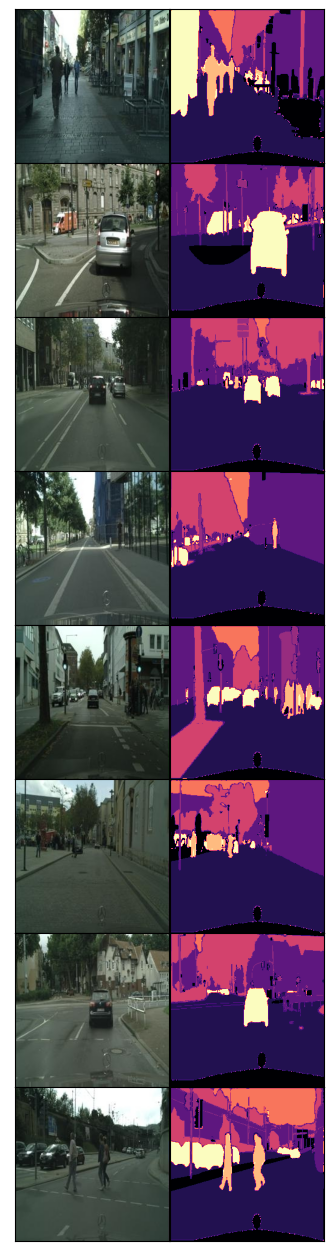

In [16]:
fig, axes = plt.subplots(cfg.BATCH_SIZE, 2, figsize=(4, 2.*cfg.BATCH_SIZE), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(cfg.BATCH_SIZE):
    img, mask = X_train[i], Y_train[i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(img.permute(1,2, 0))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

# Save a batch from test dataloader for later evaluation

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


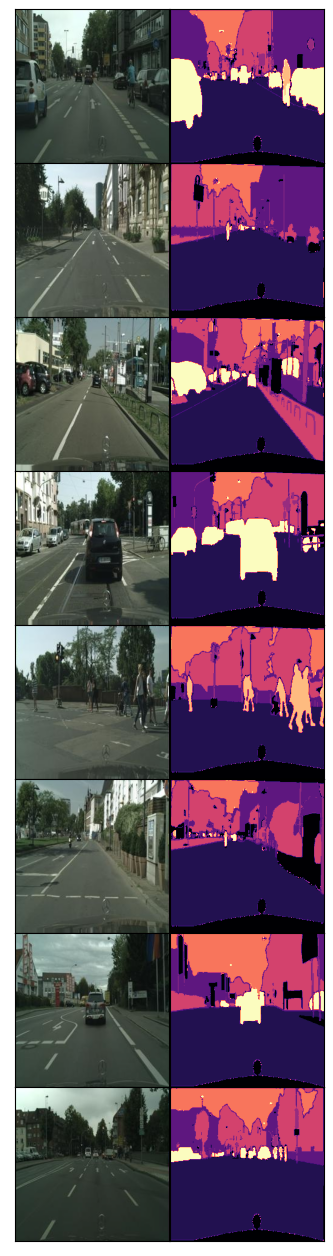

In [17]:
eval_batch_data = next(iter(val_dataloader))

# the images coming from the dataset are now preprocessed : 
# images are normalized using means and standard deviations coming from ImageNet (x' = (x - \mu) / \std)
# to decode, multiply by standard deviation, and add mean (x = x' * \std + \mu)

def decode_image(img : torch.Tensor) -> torch.Tensor:
    return img * torch.Tensor(cfg.STD) + torch.Tensor(cfg.MEAN)

print(eval_batch_data[0].shape, eval_batch_data[1].shape)
batch_size = eval_batch_data[0].shape[0]
fig, axes = plt.subplots(batch_size, 2, figsize=(4, 2.*batch_size), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(batch_size):
    img, mask = eval_batch_data[0][i], eval_batch_data[1][i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

## Extra Losses

### Brief Description
Because our task is pixelwise classification, initially we could think that we could just use crossentropy to predict the class of the pixel. This is used, however there exists also many other losses, which are often either used or combined, to get much better results. <br>
Other popular metrics include : 
- DICE coefficient (or Sørensen–Dice coefficient). This loss is used to compare the pixelwise agreement between the predicted segmentation and mask, and is represented as : $$ DICE(X, X_{truth}) = \frac{2|X \cap X_{truth}|}{|X| + |X_{truth}|}$$ This metrics takes values from 0 (no overlap at all) and 1 (full overlap). This loss his widely adapted to calculate the simillarity of two images [2]. DICE loss has a large benefit in comparison to cross entropy, that it considers the loss information both locally and globally (in comparison to crossentropy which cares only about local). It is consider much better loss for semantic segmenation, especially in inbalanced classes problems. <br><br>
- Intersection over Union (or Jaccard coefficient). Simillarly to DICE, This loss is also used to compare the pixelwise agreement between the predicted segmenation and mask. It's quite simillar to DICE in it's formulation, and it's given by $$ IoU(X, X_{truth}) = \frac{|X \cap X_{truth}|}{|X \cup X_{truth}|} = \frac{|X \cap X_{truth}|}{|X|+ |X_{truth}| - |X \cap X_{truth}|} $$ This metric is simple, intuitive (devide the Area of Overlap over Area of Union : this achieves a score from 0 (no overlap) to 1 (we perfectly classified everything, and intersection of truth/prediction and union of them are the same)). It provides the same benefits as DICE : it is concerned with both local and global alignment, providing a better value to optimize then cross entropy. Both metrics are used for semantic segmentaion and overall are quite simillar however there is at least one important different I know of : IoU gives more weight to intersection than IoU (because of the factor 2, which I believe means that some small errors are tolerated in DICE). 
<br>

There exists many more losses which I will explore in other notebooks, many of which are mentioned in really nice survey [2].


### Multiclass
Important consideration of each of this losses is that most often they are only mentioned for binary classes. Most likely however, we will deal with multiclass prediction problem. A way to deal with it, is to one hot encode our predictions, and calculate DICE or IoU for each of the classes. Then calculate the mean of them (or weighted mean) to get the final score.

### great articles / references : 
- [1]https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
- [2]https://arxiv.org/pdf/2006.14822.pdf
- [3]https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b
- [4]https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou/276144#276144

In [18]:
# dice loss
# awesome implementation for DICE can be found here
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
def dice_coeff(inp : Tensor, tgt : Tensor, eps=cfg.EXTRA_LOSS_EPS):
    sum_dim = (-1, -2, -3)

    # calculation of intersection   
    inter = 2 *(inp * tgt).sum(dim=sum_dim)

    # calculate the sum of |inp| + |tgt|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # calcaute the dice    
    dice = (inter + eps) / (sets_sum + eps)

    # average the dice of classwise
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = cfg.EXTRA_LOSS_EPS):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

## Evaluate the model

In [19]:
def evaluate_model(model, val_dataloader, epoch, epochs, criterion,
                   with_dice_loss=True, with_IoU_loss=False):
    global epoch_to_fig 
    val_loss = 0
    val_dice = 0
    val_IoU = 0
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} ; val Loss 0") as pbar:
        model.eval()
        examples_so_far = 0
        for i, batch in enumerate(val_dataloader):
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()                
                
            # predictions
            masks_pred = model(images)
            
            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item() * images.shape[0]
            examples_so_far += images.shape[0]

            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_dice_loss:
                loss += dice
            val_dice += images.shape[0] * (1.-dice.item())
                
            IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_IoU_loss:
                loss += IoU
            val_IoU += images.shape[0] * (1.-IoU.item())
            
            pbar.update(1)
                
            descr = f"Epoch {epoch}/{epochs} ; val Loss {round(val_loss / examples_so_far ,3)}, val IoU : {round(val_IoU / examples_so_far ,3)}, val Dice : {round(val_dice / examples_so_far ,3)}"               
            pbar.set_description(descr)

    eval_summary = {}
    eval_summary["validation_loss"] = val_loss / examples_so_far
    eval_summary["validation_DICE_coefficient"] = val_dice / examples_so_far
    eval_summary["validation_IoU_coefficient"] = val_IoU / examples_so_far

    return eval_summary

## Training the model

In [20]:
def train_model(model, device, train_dataloader,
                val_dataloader, epochs=10, lr=1e-4, update_pb_every_batch = 1,
                with_dice_loss=True, with_IoU_loss=False):
    global global_step
    
    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    returned_data = []

    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_IoU = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss,3)}") as pbar:
            model.train()
            optimizer.zero_grad()
            examples_so_far = 0
            for i,batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                images, true_masks = batch[0], batch[1]
                
                images = images.to(device)
                true_masks = true_masks.to(device).long()
                                
                masks_pred = model(images)
                
                loss = criterion(masks_pred, true_masks)
                if with_dice_loss:
                    dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += dice
                    training_dice += images.shape[0] * (1.-dice.item())
                
                if with_IoU_loss:
                    IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += IoU
                    training_IoU += images.shape[0] * (1.-IoU.item())
                
                # Backward and optimize
                #loss.backward()
                accelerator.backward(loss)
                optimizer.step()
                
                global_step += 1
                training_loss += images.shape[0] * loss.item()
                examples_so_far += images.shape[0]

                pbar.update(1)
                if i % update_pb_every_batch == 0:
                    descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}"        
                    if with_dice_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg DICE : {round(training_dice / examples_so_far ,3)}"   
                    elif with_IoU_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg IoU : {round(training_IoU / examples_so_far ,3)}"
                    
                    pbar.set_description(descr)
        
        epoch_summary = {}
        epoch_summary["training_loss"] = training_loss / examples_so_far
        if with_dice_loss:
            epoch_summary["training_DICE_coefficient"] = training_dice / examples_so_far
        if with_IoU_loss:
            epoch_summary["training_IoU_coefficient"] = training_IoU / examples_so_far


        val_summary = evaluate_model(model, val_dataloader, epoch, epochs, criterion, with_dice_loss=with_dice_loss, with_IoU_loss=with_IoU_loss)
        epoch_summary = {**epoch_summary, **val_summary}
        returned_data.append(epoch_summary)

    return returned_data

## Show the outputs

In [21]:
def show_inference(batch, predictions):

    batch_size = batch[0].shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[0][i], batch[1][i]  

        axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='magma')
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap='magma')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")



## plot the losses/coefficients

In [22]:
def plot_losses_coeffs(training_val_summary):

    if cfg.SNS_STYLE is not None:
        sns.set(style=cfg.SNS_STYLE)

    training = defaultdict(list)
    validation = defaultdict(list)

    m = 0

    for epoch_summary in training_val_summary:
        keys = list(epoch_summary.keys())

        training_keys = [k for k in keys if k.startswith("training")]
        for k in training_keys:
            training[k[len("training")+1:]].append(epoch_summary[k])

        val_keys = [k for k in keys if k.startswith("validation")]
        for k in val_keys:
            validation[k[len("validation")+1:]].append(epoch_summary[k])

    fig, axes = plt.subplots(len(validation.keys()), 1, figsize=(10, 10), sharex=True)

    for i,k in enumerate(validation.keys()):

        if k in training:
            axes[i].plot(training[k], marker='o', linestyle='--', label="training", linewidth=3)


        if validation[k][-1] > validation[k][0]:
            best_idx = np.argmax(validation[k])
        else:
            best_idx = np.argmin(validation[k])
        
        best = validation[k][best_idx]

        axes[i].set_title(f"{k} (validation best : {round(best, 4)})", fontsize=14, fontweight="bold")
        axes[i].plot(validation[k], label="validation", marker='o', linestyle='--', linewidth=3)

        axes[i].plot([0, best_idx], [best, best], linewidth=2, linestyle="--", color='black', alpha=0.5)
        m = max(m, len(validation[k]))
        axes[i].legend()

    axes[-1].set_xticks(list(range(0, m)))
    axes[-1].set_xticklabels(list(range(1, m + 1)))
    sns.set(style="white")

## Show the CE vs DICE eval

### Training / Eval for CE vs DICE comparison

In [23]:
def train_model_CE_DICE(model, device, train_dataloader,
                val_dataloader, Beta=0., epochs=10, lr=1e-4, update_pb_every_batch = 1):
    global global_step
    
    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    cross_entropy = nn.CrossEntropyLoss()
    
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    returned_data = []

    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_CE = 0
        
        model.train()
        optimizer.zero_grad()
        examples_so_far = 0
        for i,batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()
                                
            masks_pred = model(images)
                
            CE   = cross_entropy(masks_pred, true_masks)
            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            loss = Beta * CE + (1. - Beta) * dice
            training_dice += images.shape[0] * (1.-dice.item())
            training_CE += images.shape[0] * CE.item()
                
            # Backward and optimize
            #loss.backward()
            accelerator.backward(loss)
            optimizer.step()
                
            global_step += 1
            training_loss += images.shape[0] * loss.item()
            examples_so_far += images.shape[0]
        
        epoch_summary = {}
        epoch_summary["training_loss"] = training_loss / examples_so_far
        epoch_summary["training_CE"] = training_CE / examples_so_far
        epoch_summary["training_DICE_coefficient"] = training_dice / examples_so_far
        
        val_summary = evaluate_model_CE_DICE(model, val_dataloader, epoch, epochs)
        epoch_summary = {**epoch_summary, **val_summary}
        returned_data.append(epoch_summary)

    return returned_data


def evaluate_model_CE_DICE(model, val_dataloader, epoch, epochs):
    global epoch_to_fig 
    val_CE = 0
    val_dice = 0
    val_IoU = 0
    cross_entropy = nn.CrossEntropyLoss()

    model.eval()
    examples_so_far = 0
    for i, batch in enumerate(val_dataloader):
        images, true_masks = batch[0], batch[1]
                
        images = images.to(device)
        true_masks = true_masks.to(device).long()                
                
        # predictions
        masks_pred = model(images)
            
        loss = cross_entropy(masks_pred, true_masks)
        val_CE += loss.item() * images.shape[0]
        examples_so_far += images.shape[0]

        dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
        val_dice += images.shape[0] * (1.-dice.item())
                
        IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
        val_IoU += images.shape[0] * (1.-IoU.item())

    eval_summary = {}
    eval_summary["validation_CE"] = val_CE / examples_so_far
    eval_summary["validation_DICE_coefficient"] = val_dice / examples_so_far
    eval_summary["validation_IoU_coefficient"] = val_IoU / examples_so_far

    return eval_summary

### CE vs DICE comparison plotting/training utils

In [24]:
def plot_summaries_preds(summaries, preds):
    true_val = eval_batch_data[1].permute(1, 2, 0)  
    images = [true_val] + [*preds]
    
    batch_size = images[0].shape[-1]
    
    fig, axes = plt.subplots(batch_size, len(images), figsize=(18, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.0, wspace=0)

    for i in range(len(images)):
        for j in range(batch_size):

            axes[j, i].imshow(images[i][:,:,j].cpu())    
            axes[j,i].set_xticks([])
            axes[j,i].set_yticks([])
            if i == 0 and j == 0:
                summary = summaries[i]
                axes[0,0].set_title(f"True Mask")
    
            elif i == 1 and j == 0:
                axes[j,i].set_title(f"Sum of DICE+CE\nCE={round(summary['VAL_LOSS'],2)},DICE={round(summary['VAL_DICE'],2)}")
                
            elif j == 0:
                summary = summaries[i-1]
                axes[j,i].set_title(f"Beta={round(summary['BETA'], 2)}\nCE={round(summary['VAL_CE'],2)},DICE={round(summary['VAL_DICE'],2)}")


def get_summaries_preds_for_comparison(delta_Beta, model_ref, model_params, model_mixed, summary_mixed, epochs=25, lr=3e-4):

    summaries = []
    predictions = []
    device = "cuda"

    d = defaultdict(list)
    for x in summary_mixed:
        for k,v in x.items():
            d[k].append(v)
                
    LOSS, DICE, V_LOSS, V_DICE, V_IOU = d["training_loss"][-1], d["training_DICE_coefficient"][-1], d["validation_loss"][-1], d["validation_DICE_coefficient"][-1], d["validation_IoU_coefficient"][-1]
    summaries.append({"LOSS" : LOSS, "DICE" : DICE, "VAL_LOSS" : V_LOSS, "VAL_DICE" : V_DICE, "VAL_IOU" : V_IOU})
    predictions.append(torch.argmax(model_mixed(eval_batch_data[0].to(device)), dim=1).permute(1, 2, 0))

    for Beta in np.arange(0, 1. + 1e-9, delta_Beta):
        start = time()
        model = model_ref(**model_params)
        model = model.to(device)
        summary = train_model_CE_DICE(model, device, train_dataloader, val_dataloader, Beta=Beta,
                                                lr=lr, epochs=epochs, update_pb_every_batch=10)
        
        d = defaultdict(list)
        for x in summary:
            for k,v in x.items():
                d[k].append(v)
                
        CE, DICE, V_CE, V_DICE, V_IOU = d["training_CE"][-1], d["training_DICE_coefficient"][-1], d["validation_CE"][-1], d["validation_DICE_coefficient"][-1], d["validation_IoU_coefficient"][-1]

        summaries.append({"BETA" : Beta,  "CE" : CE, "DICE" : DICE, "VAL_CE" : V_CE, "VAL_DICE" : V_DICE, "VAL_IOU" : V_IOU})
        predictions.append(torch.argmax(model(eval_batch_data[0].to(device)), dim=1).permute(1, 2, 0))
        print(f"[{int(time() - start)}s] Model with Beta={Beta} finished with training CE : {CE}, training DICE : {DICE}, validation CE : {V_CE}, Validation DICE : {V_DICE}, Validation IOU : {V_IOU}")


    return summaries, predictions


# Unet

## Description<br>
Unet is one of the most popular architectures for semantic segmentation, which won multiple semantic segmentation competitions for medical images [1]. This architecture was introduced in the paper **\"U-Net: Convolutional Networks for Biomedical Image Segmentation\"**. The most likely reason why Unet is popular is that it works well and the architecture itself is easy to code and intuitive. It is a fully convolutional neural network (the main computational operation is 2D convolution, with no Dense layers) and the original architecture is represented in figure a). The architecture is nicely symmetric and intuitive. We start with an input image and apply convolutions twice. we then save this output, and downscale (using max-pooling layer), which results in an image of size $(\frac{h}{2}, \frac{w}{2})$. We continue to follow this pattern until we reach a bottleneck layer (bottom-middle layer). After applying 2 convolutions, we apply deconvolution (which will upscale the image, from $(h,w) \rightarrow (2h, 2w)$). There a crucial step is done: the outputs from applying the convolutions (left-side) are concatenated with the deconvolutions (the upsampling). This is done in order to localize high resolution, and convolutions can learn to assemble a more precise output based on this information [1]. An important property of this architecture is that upsampling layers has also many channels, which should allow propagating information context properly. <br><br>

Some other notes :
- Unet paper also introduces a data augmentation for semantic segmentation. Data augmentation is a very popular technique to make the network generalize better, by perturbing or modifying the dataset. It also allows training networks with smaller datasets (as we constantly perturb the data). They achieve that by introducing **elastic deformations**.
- An important observation in the architecture that there is that the output image is a different size than the input image. Depending on the application, it might or might not matter. [TODO] Making the output the same as the input has some fairly hidden drawbacks, find a paper. However in order to simplify the implementation, and because at the end we are most likely interested in the pixel-wise classification (output size = input size). This will be achieved by adding paddings to the convolutions and making sure that max pool layers will not be applied to odd sizes.

[1] https://arxiv.org/abs/1505.04597

## Architecture

In [22]:
class ConvBlock(nn.Module):
    """apply twice convolution followed by batch normalization and relu. Preserves the width and height of input"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    """Downscaling with maxpool then ConvBlock, transforming an input with (h, w, in_channels) to (h/2, w/2, out_channels)"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x
 

class UpScale(nn.Module):
    """apply upscaling and then convolution block transforming an input with (h,w,in_channels) to (2h, 2w, out_channels).
       Forward function also simplifies Unet propagation by taking two inputs : first one from constantly propagating (from upscaling)
       and the second one, which is the output from applying Downscale (first input is upscaled, then concatenated with second)"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

number_of_classes = len(set(name_to_category.values()))
summary(Unet(3, number_of_classes), input_data=eval_batch_data[0])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [8, 8, 256, 256]          --
├─DoubleConv: 1-1                             [8, 32, 256, 256]         --
│    └─Sequential: 2-1                        [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                       [8, 32, 256, 256]         864
│    │    └─BatchNorm2d: 3-2                  [8, 32, 256, 256]         64
│    │    └─ReLU: 3-3                         [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                       [8, 32, 256, 256]         9,216
│    │    └─BatchNorm2d: 3-5                  [8, 32, 256, 256]         64
│    │    └─ReLU: 3-6                         [8, 32, 256, 256]         --
├─Down: 1-2                                   [8, 64, 128, 128]         --
│    └─Sequential: 2-2                        [8, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-7                    [8, 32, 128, 128]         --
│    │    └─Doub

## Training

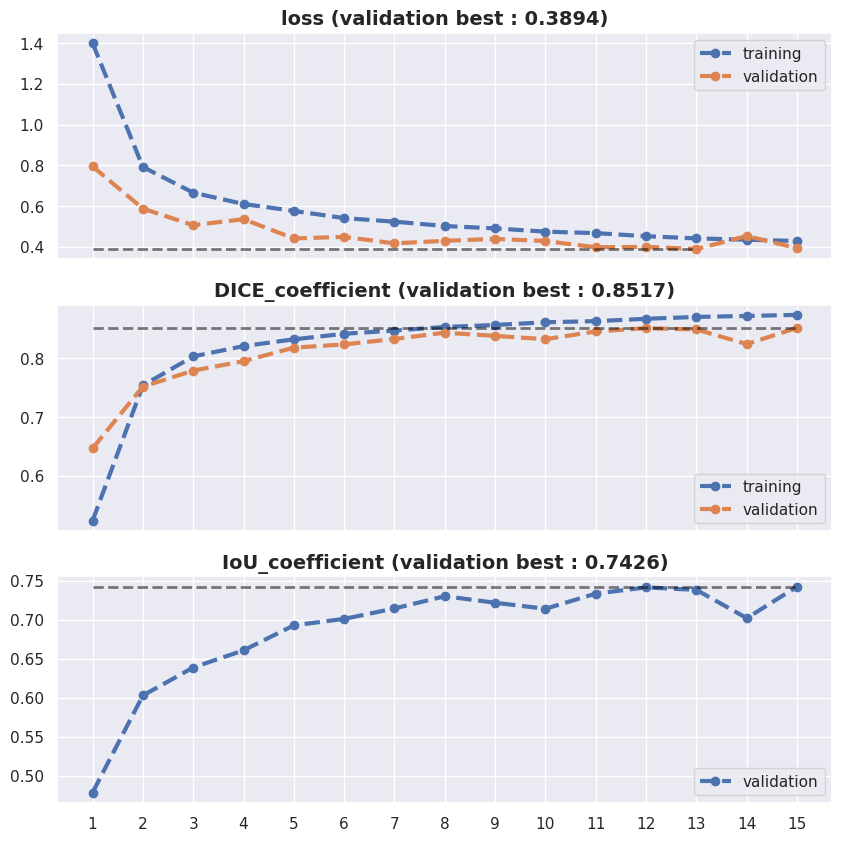

In [23]:
device = "cuda"
model = Unet(3, number_of_classes)
model = model.to(device)

Unet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=cfg.SINGLE_NETWORK_TRAINING_EPOCHS, update_pb_every_batch=10)

clear_output(True)
plot_losses_coeffs(Unet_training_val_summary)


## Inference (Show results)

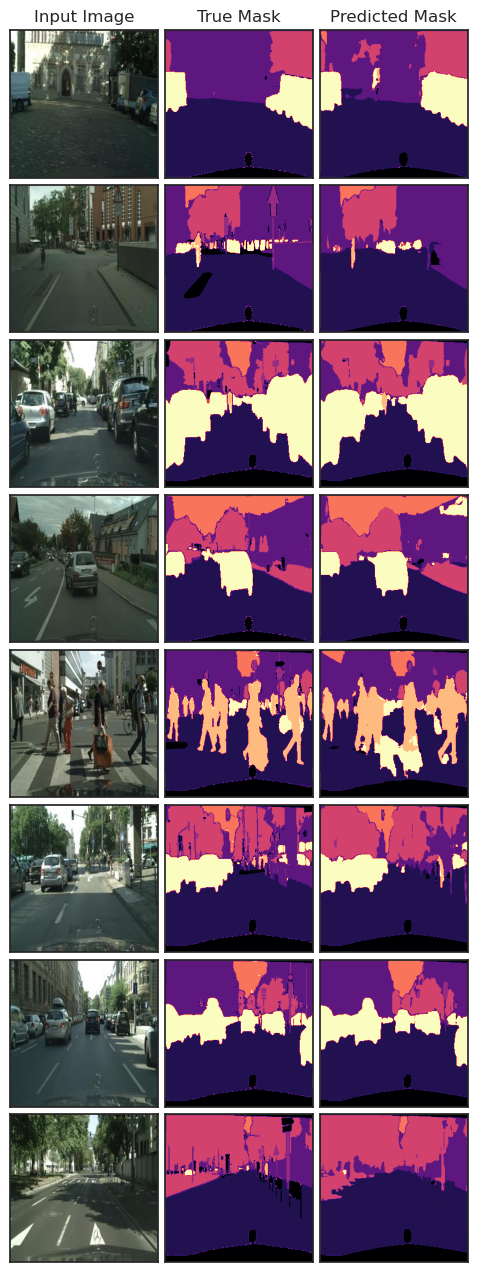

In [24]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

## Comparison of how loss affects the prediction (CE and DICE)

[355s] Model with Beta=0.0 finished with training CE : 1.064624798959043, training DICE : 0.892328451240764, validation CE : 1.283546018600464, Validation DICE : 0.8723598012924194, Validation IOU : 0.7746486573219299
[356s] Model with Beta=0.2 finished with training CE : 0.34385640691308417, training DICE : 0.8893371027657966, validation CE : 0.4308304190635681, Validation DICE : 0.8656443748474121, Validation IOU : 0.764423855304718
[357s] Model with Beta=0.4 finished with training CE : 0.30475275273082636, training DICE : 0.8798635683540537, validation CE : 0.38178606462478637, Validation DICE : 0.8521829762458801, Validation IOU : 0.7436099314689636
[360s] Model with Beta=0.6000000000000001 finished with training CE : 0.2967829229250675, training DICE : 0.8704646546099366, validation CE : 0.40480260705947874, Validation DICE : 0.8456645059585571, Validation IOU : 0.7338861970901489
[361s] Model with Beta=0.8 finished with training CE : 0.29392515658330515, training DICE : 0.8634498

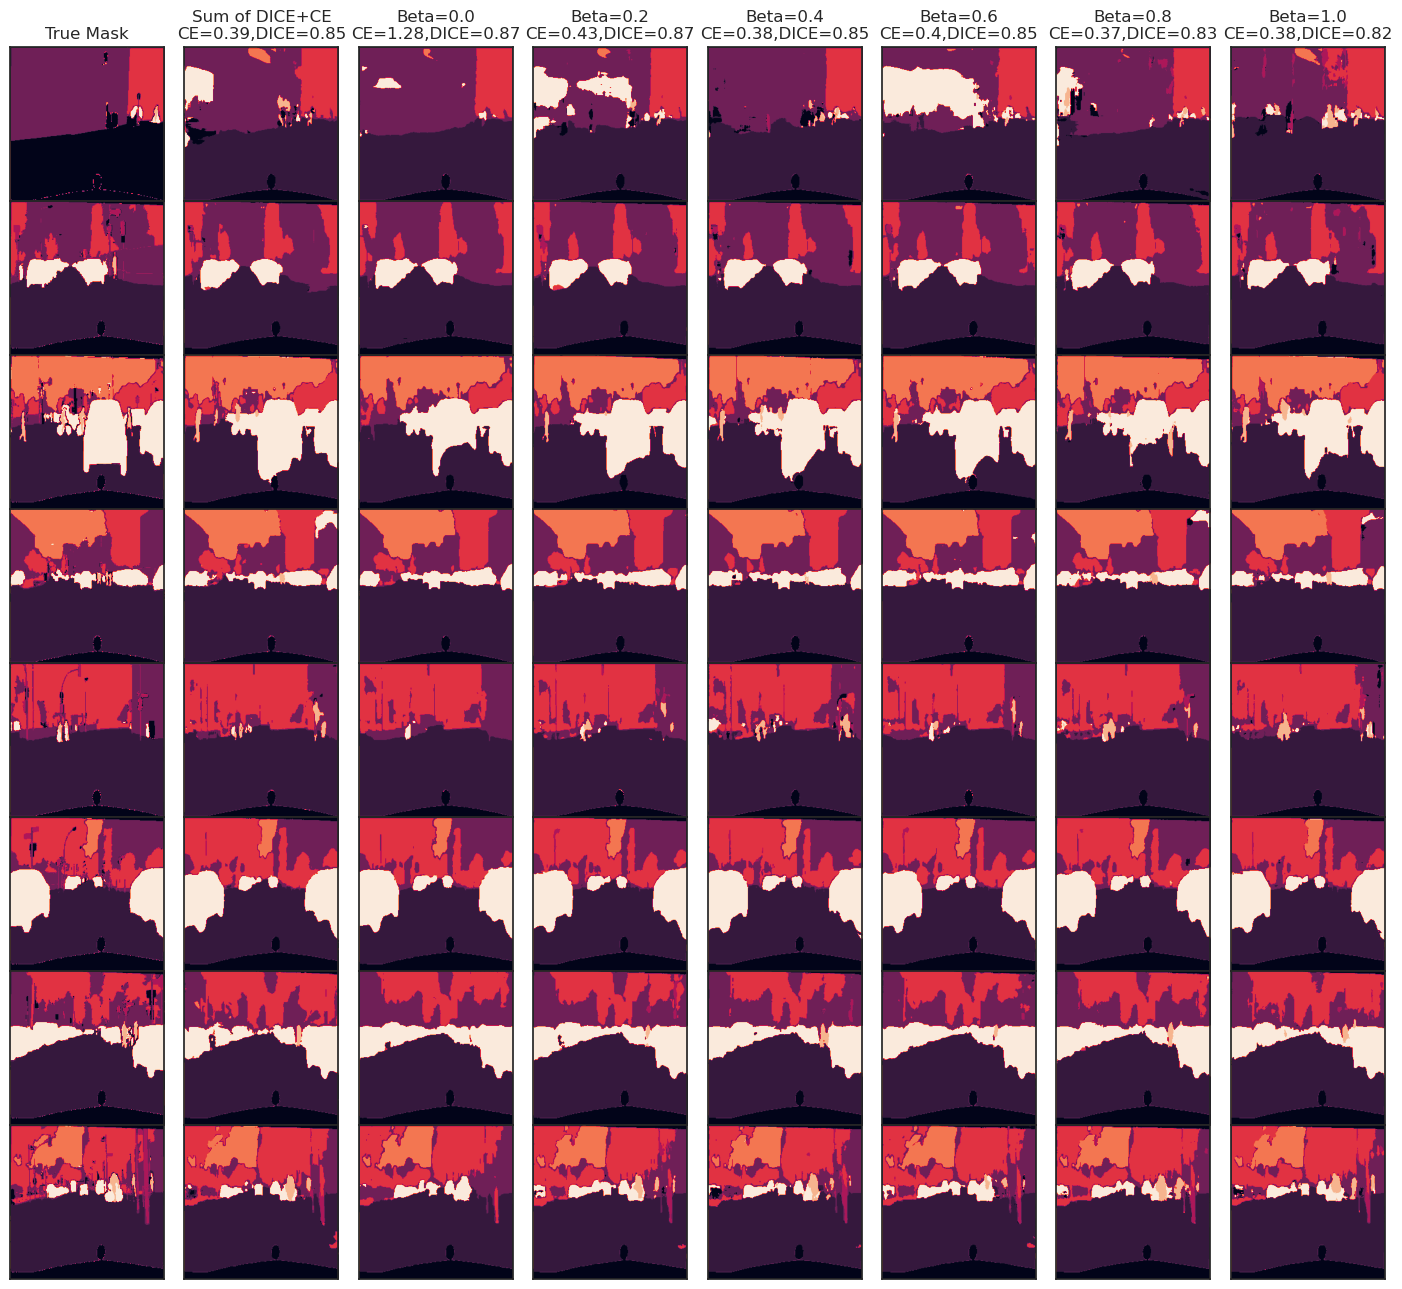

In [25]:
# LONG COMPUTATION !

summaries, preds = get_summaries_preds_for_comparison(cfg.DELTA_BETA, Unet, {"n_channels" : 3, "n_classes" : number_of_classes},
                                                      model_mixed=model, summary_mixed=Unet_training_val_summary, epochs=cfg.CE_VS_DICE_EVAL_EPOCHS)

plot_summaries_preds(summaries, preds)

# ENet

## Description
UNet is great and very commonly used. In typical usages of this network however, it has a lot (millons) parameters. For autonomous cars, we care not only about the accuracy of precision (which is of course extremely important and there is a lot of research done in validaton and verfication of neural networks) but also how fast we can came up with this result. Camera systems are not perfect, and regular cameras can create a blurrly, non ideal pictures especially when moving (fast). A very famous quote comes to mind, saying "Garbage In, Garbage Out". Despite having an extremely good classifier, perhaps a particular input image will be quite distorted and classifier won't be able to handle that. If we could make inference fast however, the probability that at least some of the pictures will be good quality (came from appropriate distribution) and contain good information greatly increases. <br><br>

Researchers created many architectures for fast and accurate semantic segmenation. A good, comprehensive list can be found here [2]. The first architecture we explore will be ENet. This architecture was introduced in 2016 in paper "ENet: A Deep Neural Network Architecture for Real-Time Semantic Segmentation" and achieved real-time (15-20 fps) on embedded device (NVIDIA TX1, an under 10W module with CUDA capability). The network itself uses many "tricks" and is very lightweight : model itself weights only 0.7MB for 640 x 480 image input. Some of the tricks to make it work, are described below as well as in the paper [1] : 
- The network itself has an __encoder-decoder architecture__. This is different to UNET, where it follows kind of encoder-decoder architecture, but outputs from encoder are combined in decoder layers with upsampled values. Here the network is simpler, and it is constantly applying forward blocks (no taking outputs from decoder as in UNET, however indices from maxPool operations are saved and used in Upsampling) : (3, 512, 512) -> (16, 256, 256) -> (64, 128, 128) -> (128, 64, 64) -> (64, 128, 128) -> (16, 256, 256) -> (C, 512, 512). Another good thing, is that input size is equal to output size.
- it downsamples early : as authors point out, processing large frames is expensive, therefore downscaling is applied as soon as possible (first two blocks reduce the input size ). An interesting insight from the paper : __"The idea behind it, is that visual information is highly spatially redundant, and thus can be compressed into a more efficient representation. Also, our intuition is that the initial network layers should not directly contribute to classification. Instead, they should rather act as good feature extractors and only preprocess the input for later portions of the network"__
- An important improvement (which makes the networks much scalable) is __factoring Filters (asymmetric convolutions)__. They decompose applying a convolution of N x N to applying two subsequent convolution with kernel sizes 1xN and Nx1 respectively.   
- __large encoder and small decoder__ (encoder should work simillarly to image classification networks, decoder should only focus on upsampling the output of encoder and only fine-tune the details )
- Authors observed that performing pooling followed by convolution (which increases the dimensionality by making the output channel number greater than input channels) introduces a represetation bottleneck. It is however cheaper to do (Pooling so reducing the number of pixel to 1/4 of orignal input, and convolutions) in comparison to other way around (convolution on original number of pixels, then downscaling). __The authors decided to do pooling operation in parallel with convolution with stride of 2, and concatenate feature maps.__
- different nonlinearity (using PREeLU instead of ReLU)
<br><br>
[1] https://arxiv.org/abs/1606.02147<br>
[2] https://paperswithcode.com/task/real-time-semantic-segmentation<br>
[3] https://github.com/davidtvs/PyTorch-ENet/blob/master/models/enet.py (reference implementation)

## Architecture

In [1]:
# Original implementaton can be found here https://github.com/davidtvs/PyTorch-ENet/blob/master/models/enet.py

class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.

    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)

class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.

    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.

    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.

    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices

class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.

    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.

    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

class ENet(nn.Module):
    """Generate the ENet model.

    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.

    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        x = self.regular5_1(x)
        x = self.transposed_conv(x, output_size=input_size)

        return x

number_of_classes = len(set(name_to_category.values()))
summary(ENet(number_of_classes), input_data=batch[0])

NameError: name 'nn' is not defined

## Training

In [ ]:
device = "cuda"
model = ENet(number_of_classes)
model = model.to(device)
ENet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=20, update_pb_every_batch=10)

clear_output(wait=True)
plot_losses_coeffs(ENet_training_val_summary)

## Inference (Show results)

In [ ]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

## Comparison of how loss affects the prediction (CE and DICE)

In [ ]:
# LONG COMPUTATION !

summaries, preds = get_summaries_preds_for_comparison(cfg.DELTA_BETA, ENet, {"num_classes" : number_of_classes},
                                                      model_mixed=model, summary_mixed=ENet_training_val_summary, epochs=cfg.CE_VS_DICE_EVAL_EPOCHS)

plot_summaries_preds(summaries, preds)

# ESNET
## https://arxiv.org/pdf/1906.09826.pdf

## Description

The research on finding fast and well performing architectures for semantic segmentation is very active and there a lot of different architectures. A more recent than ENet and UNet, from 2019 is ESNet from paper "ESNet: An Efficient Symmetric Network for Real-time Semantic Segmentation" which is an extension of previously discussed ENET. The architecutre is quite simillar to ENet : simillar encoder-decoder architecture, encoder-decoder architecture, presence of techniques such as factorized convolutions. 
- The core is 4 blocks : __Downscaling block__ (very simillar to ENet), __Upsampling block__ (very simillar to ENet) and 2 new blocks : __Factorized convolution unit__ (FCU) and __parallel factorized convolution unit__ (PFCU), which is a new strategy in designs of residual layers, but with lower computational complexity [1] (by doing 1x1 convolutions and factorized convolutions with 1D kernels). 


[1] https://arxiv.org/pdf/1906.09826.pdf

## Architecture

In [26]:
class Downscale (nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Downscale,self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel-in_channel, (3, 3), stride=2, padding=1, bias=True)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.bn = nn.BatchNorm2d(out_channel, eps=1e-3)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, input):
        x1 = self.pool(input)
        x2 = self.conv(input)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        output = torch.cat([x2, x1], 1)
        output = self.bn(output)
        output = self.relu(output)
        return output

class FCU(nn.Module):
    def __init__(self, chann, kernel_size,dropprob, dilated, bias=True):  
        super(FCU,self).__init__()

        padding = int((kernel_size-1)//2) * dilated

        self.conv3x1_1 = nn.Conv2d(chann, chann, (kernel_size,1), stride=1, padding=(int((kernel_size-1)//2)*1,0), bias=bias)
        self.conv1x3_1 = nn.Conv2d(chann, chann, (1,kernel_size), stride=1, padding=(0,int((kernel_size-1)//2)*1), bias=bias)
        self.bn1 = nn.BatchNorm2d(chann, eps=1e-03)
        self.conv3x1_2 = nn.Conv2d(chann, chann, (kernel_size,1), stride=1, padding=(padding,0),  bias=bias, dilation = (dilated,1))
        self.conv1x3_2 = nn.Conv2d(chann, chann, (1,kernel_size), stride=1, padding=(0,padding), bias=bias, dilation = (1, dilated))
        self.bn2 = nn.BatchNorm2d(chann, eps=1e-03)
        self.relu = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout2d(dropprob)
        
    def forward(self, input):
        residual = input
        output = self.conv3x1_1(input)
        output = self.relu(output)
        output = self.conv1x3_1(output)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv3x1_2(output)
        output = self.relu(output)
        output = self.conv1x3_2(output)
        output = self.bn2(output)   

        if (self.dropout.p != 0):
            output = self.dropout(output)
        output = self.relu(residual+output)
        return output


class PFCU(nn.Module):
    def __init__(self,chann,bias=True):
        super(PFCU,self).__init__()
        
        self.conv3x1_1 = nn.Conv2d(chann, chann, (3,1), stride=1, padding=(1,0), bias=bias)
        self.conv1x3_1 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1), bias=bias)
        self.bn1 = nn.BatchNorm2d(chann, eps=1e-03)

        self.conv3x1_22 = nn.Conv2d(chann, chann, (3,1), stride=1, padding=(2,0), bias=bias, dilation = (2,1))
        self.conv1x3_22 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,2), bias=bias, dilation = (1,2))

        self.conv3x1_25 = nn.Conv2d(chann, chann, (3,1), stride=1, padding=(5,0), bias=bias, dilation = (5,1))
        self.conv1x3_25 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,5), bias=bias, dilation = (1,5))

        self.conv3x1_29 = nn.Conv2d(chann, chann, (3,1), stride=1, padding=(9,0), bias=bias, dilation = (9,1))
        self.conv1x3_29 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,9), bias=bias, dilation = (1,9))

        self.bn2 = nn.BatchNorm2d(chann, eps=1e-03)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, input):
        residual = input
        output = self.conv3x1_1(input)
        output = F.relu(output)
        output = self.conv1x3_1(output)
        output = self.bn1(output)
        output = F.relu(output)

        output2 = self.conv3x1_22(output)
        output2 = F.relu(output2)
        output2 = self.conv1x3_22(output2)
        output2 = self.bn2(output2)
        if (self.dropout.p != 0):
            output2 = self.dropout(output2)

        output5 = self.conv3x1_25(output)
        output5 = F.relu(output5)
        output5 = self.conv1x3_25(output5)
        output5 = self.bn2(output5)
        if (self.dropout.p != 0):
            output5 = self.dropout(output5)

        output9 = self.conv3x1_29(output)
        output9 = F.relu(output9)
        output9 = self.conv1x3_29(output9)
        output9 = self.bn2(output9)
        if (self.dropout.p != 0):
            output9 = self.dropout(output9)
        output = self.relu(residual + output2 + output5 + output9)
        return output

		
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.downscale1 = Downscale(3,16)

        self.FCU1_1 = FCU(16, 3, 0.03, 1)
        self.FCU1_2 = FCU(16, 3, 0.03, 1)
        self.FCU1_3 = FCU(16, 3, 0.03, 1)

        self.downscale2 = Downscale(16, 64)

        self.FCU2_1 = FCU(64, 5, 0.03, 1)
        self.FCU2_2 = FCU(64, 5, 0.03, 1)

        self.downscale3 = Downscale(64,128)
 
        self.PFCU1_1 = PFCU(chann=128)
        self.PFCU1_2 = PFCU(chann=128)
        self.PFCU1_3 = PFCU(chann=128)

    def forward(self, x):
        x = self.downscale1(x)
        x = self.FCU1_1(x)
        x = self.FCU1_2(x)
        x = self.FCU1_3(x)
        x = self.downscale2(x)
        
        x = self.FCU2_1(x)
        x = self.FCU2_2(x)

        x = self.downscale3(x)

        x = self.PFCU1_1(x)
        x = self.PFCU1_2(x)
        x = self.PFCU1_3(x)
        return x


class UpsamplerBlock(nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()
		
        self.conv = nn.ConvTranspose2d(ninput, noutput, 3, stride=2, padding=1, output_padding=1, bias=True)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, input):
	
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)
        return output

class Decoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.layers = nn.ModuleList()

        self.upsample1 = UpsamplerBlock(128,64)
        self.FCU1_1 = FCU(64, 5, 0, 1)
        self.FCU1_2 = FCU(64, 5, 0, 1)

        self.upsample2 = UpsamplerBlock(64,16)
        self.FCU2_1 = FCU(16, 3, 0, 1)
        self.FCU2_2 = FCU(16, 3, 0, 1)

        self.pred = nn.ConvTranspose2d( 16, num_classes, 2, stride=2, padding=0, output_padding=0, bias=True)

    def forward(self, x):
        x = self.upsample1(x)
        x = self.FCU1_1(x)
        x = self.FCU1_2(x)
        x = self.upsample2(x)
        x = self.FCU2_1(x)
        x = self.FCU2_2(x)
        x = self.pred(x)
        return x
			
# ESNet

class ESNet(nn.Module):
    def __init__(self, num_classes, giveEncoder=None):
        # use encoder to pass pretrained encoder
		
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(num_classes)
		
    def forward(self, rgb_input):
	
        output = self.encoder(rgb_input)
        return self.decoder(output)
    
number_of_classes = len(set(name_to_category.values()))
print(ESNet(number_of_classes)(eval_batch_data[0]).shape)
summary(ESNet(number_of_classes), input_data=eval_batch_data[0])

torch.Size([8, 8, 256, 256])


Layer (type:depth-idx)                        Output Shape              Param #
ESNet                                         [8, 8, 256, 256]          1,032
├─Encoder: 1-1                                [8, 128, 32, 32]          --
│    └─DownsamplerBlock: 2-1                  [8, 16, 128, 128]         --
│    │    └─MaxPool2d: 3-1                    [8, 3, 128, 128]          --
│    │    └─Conv2d: 3-2                       [8, 13, 128, 128]         364
│    │    └─BatchNorm2d: 3-3                  [8, 16, 128, 128]         32
│    │    └─ReLU: 3-4                         [8, 16, 128, 128]         --
│    └─ModuleList: 2-2                        --                        --
│    │    └─FCU: 3-5                          [8, 16, 128, 128]         3,200
│    │    └─FCU: 3-6                          [8, 16, 128, 128]         3,200
│    │    └─FCU: 3-7                          [8, 16, 128, 128]         3,200
│    │    └─DownsamplerBlock: 3-8             [8, 64, 64, 64]           7,088
│   

## Training

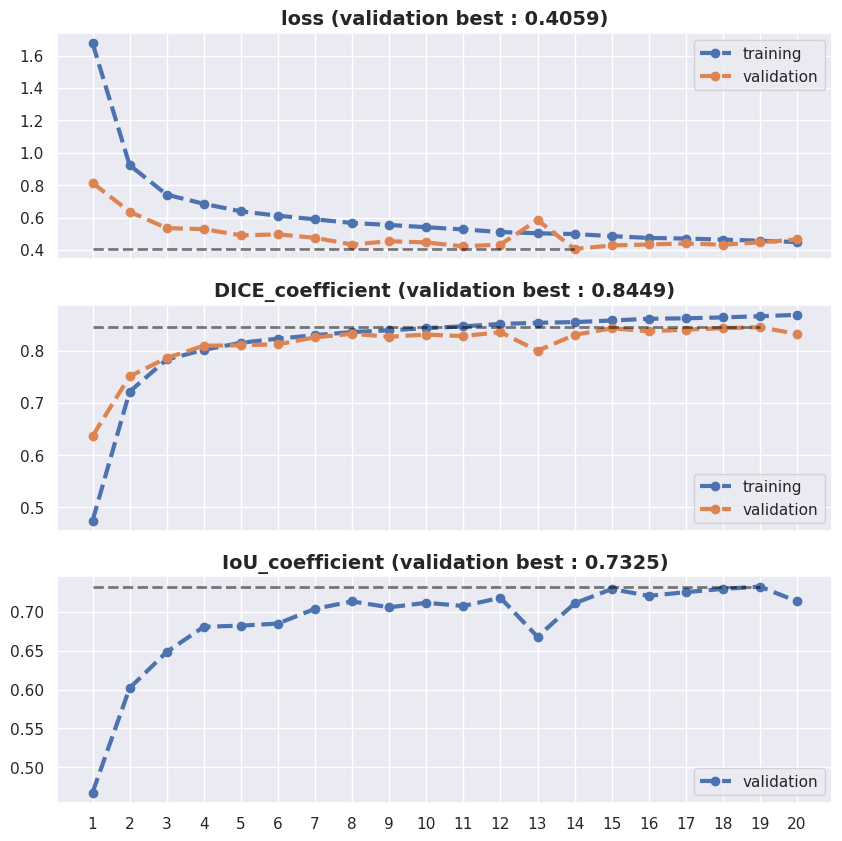

In [27]:
device = "cuda"
model = ESNet(number_of_classes)
model = model.to(device)

ESNet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=20, update_pb_every_batch=10)

clear_output(wait=True)
plot_losses_coeffs(ESNet_training_val_summary)

## Inference (Show results)

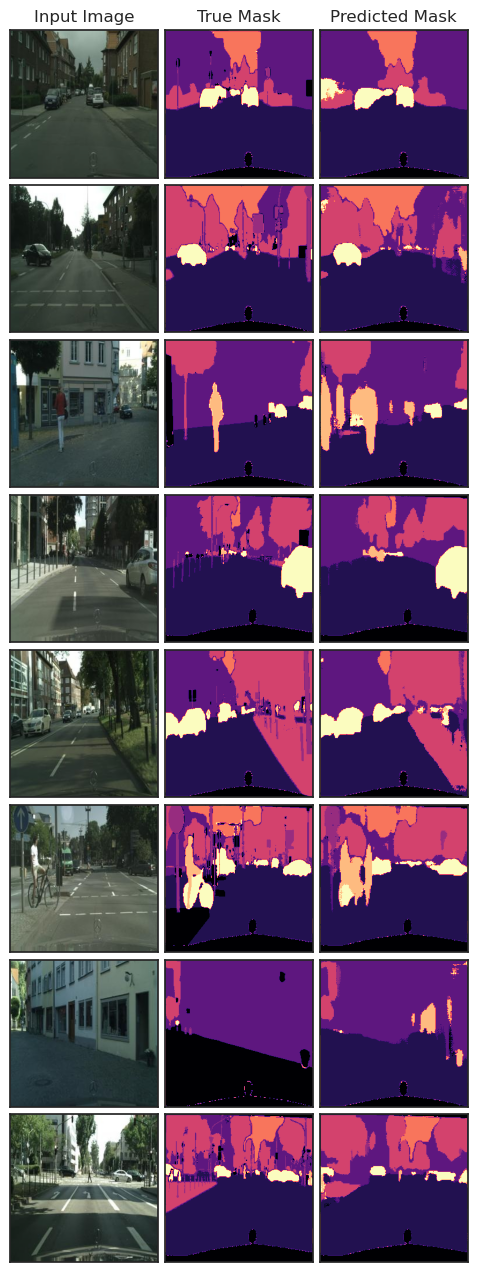

In [28]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

## Comparison of how loss affects the prediction (CE and DICE)

[266s] Model with Beta=0.0 finished with training CE : 1.2865947160400262, training DICE : 0.8805580769066049, validation CE : 1.451641526222229, Validation DICE : 0.863771644115448, Validation IOU : 0.761473798274994
[266s] Model with Beta=0.2 finished with training CE : 0.3911732567258242, training DICE : 0.8750549776413862, validation CE : 0.47601107358932493, Validation DICE : 0.8589674873352051, Validation IOU : 0.7537399563789368
[269s] Model with Beta=0.4 finished with training CE : 0.3507718755617863, training DICE : 0.8634225030506358, validation CE : 0.42840633797645566, Validation DICE : 0.8439910521507263, Validation IOU : 0.7311994681358337
[268s] Model with Beta=0.6000000000000001 finished with training CE : 0.33928788097966617, training DICE : 0.8538194264884756, validation CE : 0.4008305569887161, Validation DICE : 0.8342509355545044, Validation IOU : 0.7163387966156006
[270s] Model with Beta=0.8 finished with training CE : 0.33389899279890944, training DICE : 0.8466424

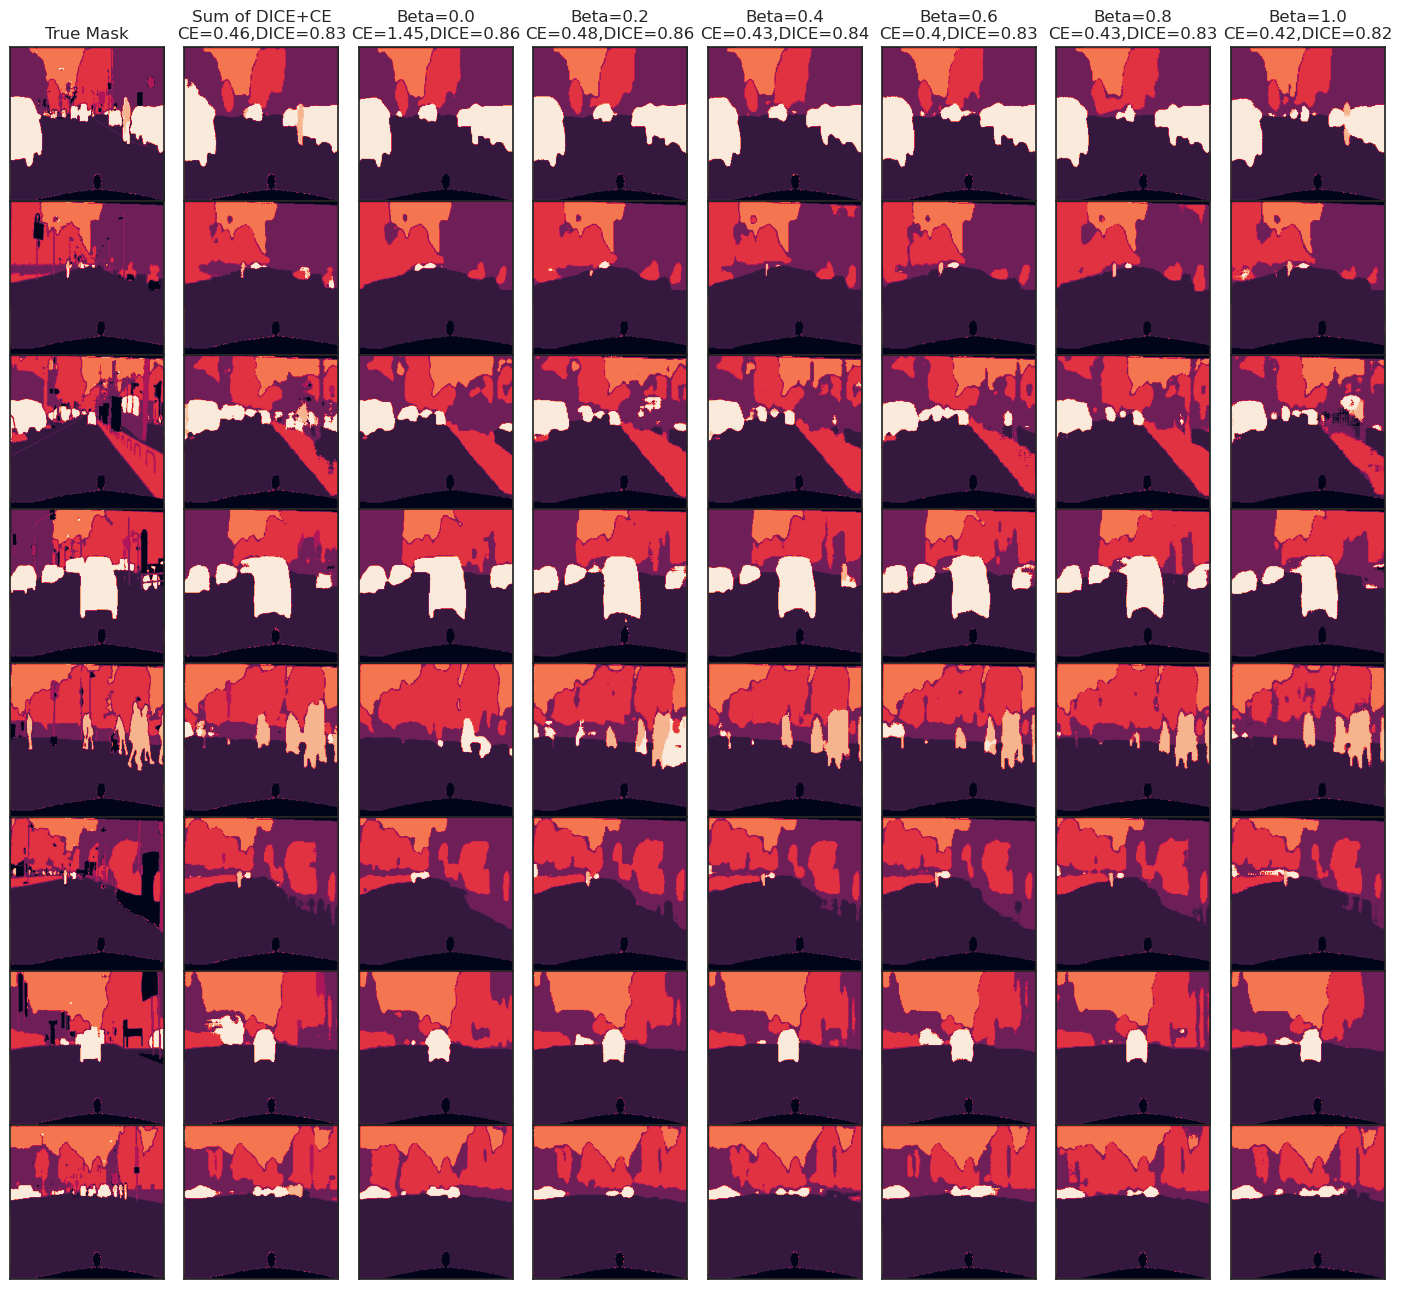

In [29]:
# LONG COMPUTATION !

summaries, preds = get_summaries_preds_for_comparison(0.2, ESNet, {"num_classes" : number_of_classes},
                                                      model_mixed=model, summary_mixed=ESNet_training_val_summary, epochs=cfg.CE_VS_DICE_EVAL_EPOCHS)

plot_summaries_preds(summaries, preds)

# DeepLabV3

## Description
So far all the networks worked pretty well, despite the fairly small number of parameters (very simillar scores). In order to see how well these networks are performing, I decided to evaluate it against some fairly standard, fairly large architecture, in order to compare the scores. I decided to go with the DeepLabV3, which is quite well performing semantic segmentation network. This network is much larger however because it's pretty standard, saved weights are available from torchvision. Few points about the DeepLabV3 :
- the network simillarly to ENet and ESNet uses __dilated convolutions__ (in paper named atrous convolutions). Dilation enlarges the field-of-view (receptive field) therefore enable encoding information at different scales. Dilation here plays I believe the most significant importance : authors argue that it will allow them to work on multi-scale context.
- Second key element is Atrous Spatial Pyramid Pooling (ASPP). Spatial Pyramid Pooling is a technique which allows capturing context at several ranges . Atrous Spatial Pyramid Pooling was introduced in previous version of deeplab (V2). In ASPP we will have in parallel (a bit simillarly to previously explored PFCU) dilated convolutions with different rates applied to the input. After applying these convoultions, the outputs are fused together (by summing them) and returned.


[1] https://arxiv.org/pdf/1706.05587.pdf <br>
[2] https://arxiv.org/abs/1606.00915v2

## Architecture

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

class DeepLabV3Wrapper(nn.Module):
    def __init__(self, num_classes):
        # use encoder to pass pretrained encoder
        super().__init__()
        self.model = deeplabv3_resnet50(num_classes=num_classes)

    def forward(self, image):
        return self.model(image)['out']
        
number_of_classes = len(set(name_to_category.values()))
model = DeepLabV3Wrapper(number_of_classes)
summary(model, input_data=batch[0])

## Training

In [ ]:
device = "cuda"
model = DeepLabV3Wrapper(number_of_classes)
model = model.to(device)

deeplabv3_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=20, update_pb_every_batch=10)

clear_output(wait=True)
plot_losses_coeffs(deeplabv3_training_val_summary)

## Inference (Show results)

In [ ]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

## Comparison of how loss affects the prediction (CE and DICE)

In [ ]:
# VERY LONG COMPUTATION !

summaries, preds = get_summaries_preds_for_comparison(0.2, DeepLabV3Wrapper, {"num_classes" : number_of_classes},
                                                      model_mixed=model, summary_mixed=deeplabv3_training_val_summary, epochs=cfg.CE_VS_DICE_EVAL_EPOCHS)

plot_summaries_preds(summaries, preds)

# Summary

This notebook was my first try on playing with semantic segmenation and documenting it. It contains some basic pytorch ( + HF accelerate) code for training semantic segmentation networks, DICE/IoU losses and few basic architectures for semantic segmentation. In next one, where I explore different dataset I will document more modern semantic segmentation networks (here all networks were from 2014-2019, the field of course is constantly coming up with new architectures, however this notebook was getting long).

<br>
Summary of results <br>

| Network Name | mDICE  | mIoU  | size of network | Inference speed | 
|---|---|---|---|---|
| UNet  |   |   |||
| ENet  |   |   |||
| ESNet  |   |   |||
| DeepLabV3  |   |   |||
